#### Function for visualizing Images

In [1]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

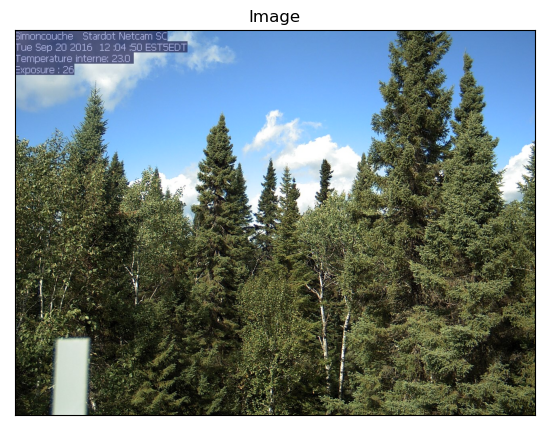

In [154]:
import cv2
import numpy as np

image = cv2.imread(r"G:\github projects\intern\image for clustering.JPG")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image = image)
H,W,_=image.shape

img = cv2.resize(image, (256,256))
img = np.expand_dims(img, axis=0)


### Load Segmentation Model

In [3]:
from keras.models import load_model
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [4]:
model = load_model(r"G:\Intern project\DATA SET\Labelled Dataset\sdgtrjsr\my_model5.h5", compile=False)

### Predict vegetations Mask

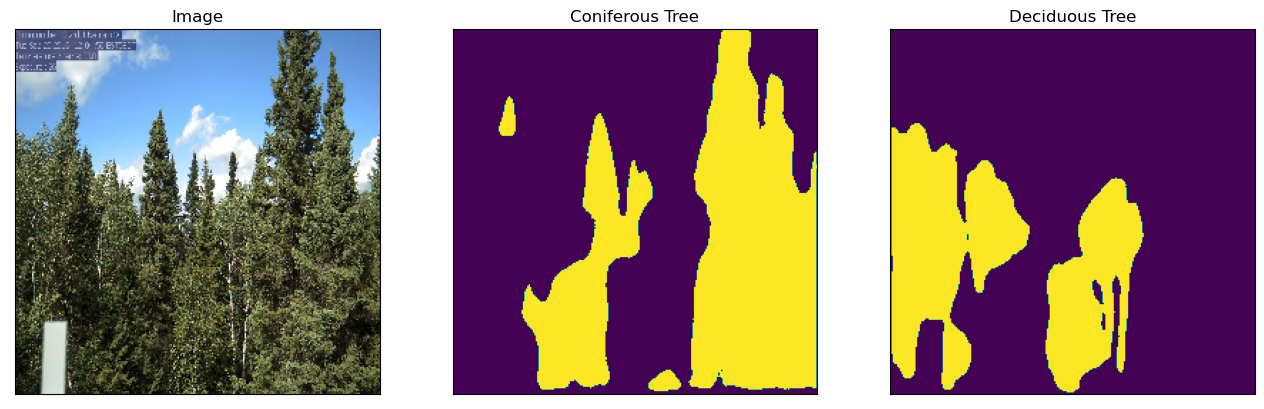

In [5]:
mask = model.predict(img,verbose=0)>0.5
visualize(
    image=img.squeeze(),
    Coniferous_tree=mask[..., 1].squeeze(),
    deciduous_tree = mask[..., 0].squeeze()
)

## Analysis On Coniferous Tree

In [6]:
mask = mask[..., 1].squeeze()

### ROIs generation using Kmean Algorithm

#### Deciding Number of ROIs
There should be 20000 pixels per ROI.
Hence, Total Number of ROIs = (Number of vegetation pixels) / (pixels per ROI)

In [7]:
points=[]
for i in range(255):
    for j in range(255):
        if(mask[i,j]>0.9):
            points.append([i,j])
points=np.array(points)

scale_h=H/255
scale_w=W/255
thresold_area=20000*(H*W/1200000)
ROI_area=int(thresold_area/(scale_h*scale_w))
n_ROIs = points.shape[0]//ROI_area
print("Total no. of ROIs:",n_ROIs)

Total no. of ROIs: 22


#### Kmeans for generation ROIs(Clusters)

In [8]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=n_ROIs,max_iter=300)
k_means.fit(points)
centroids = k_means.cluster_centers_
labels= k_means.labels_

In [9]:
clustering_image=np.zeros((256,256))
for i in range(n_ROIs):
    p=points[labels==i]
    clustering_image[p[:,0],p[:,1]]=255*(i+1)//(n_ROIs)

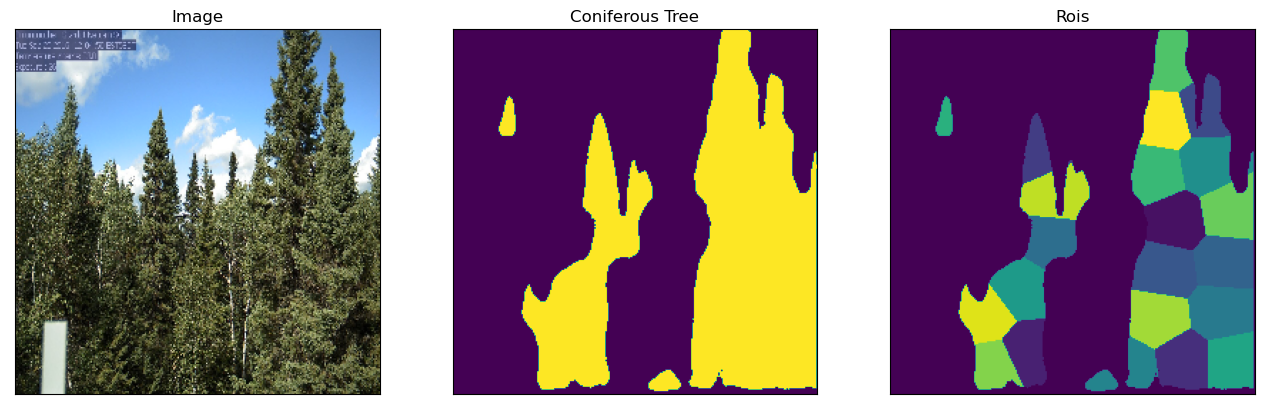

In [10]:
visualize(
    image=img.squeeze(),
    Coniferous_tree=mask,
    ROIs = clustering_image
)

### Resizing ROIs to Original Image Size

In [12]:
ROIs = []
for i in range(len(labels)):
    
    if(len(points[labels==i])<ROI_area*0.7):
        continue
    x1=min(points[labels==i][:,1])
    y1=min(points[labels==i][:,0])
    x2=max(points[labels==i][:,1])
    y2=max(points[labels==i][:,0])

    ROI_IMG = np.zeros((y2-y1+1,x2-x1+1))
    ROI_IMG[points[labels==i][:,0]-y1,points[labels==i][:,1]-x1] = 1
    
    h,w=ROI_IMG.shape
    h,w=int(scale_h*h),int(scale_w*w)
    ROI_image=cv2.resize(ROI_IMG,(w, h))
    ROI=[]
    for i in range(h):
        for j in range(w):
            if(ROI_image[i,j]>0.5):
                ROI.append([i,j])
    ROI=np.array(ROI)
    ROI[:,0]+=int(y1*scale_h)
    ROI[:,1]+=int(x1*scale_w)
    
    ROIs.append(ROI) 

#### Selecting Random 4 ROIs

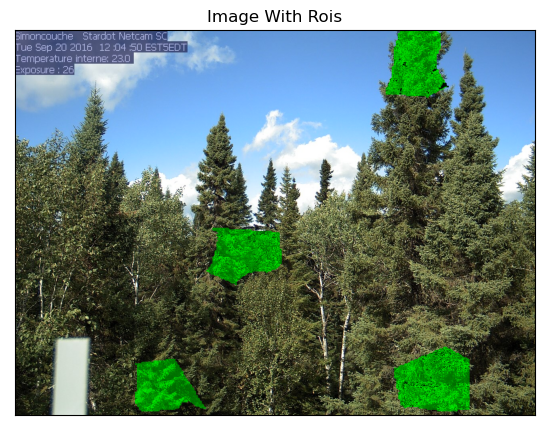

In [101]:
import random
rois=random.sample(ROIs, 4)
ROI_image = image.copy()
for r in rois:
    ROI_image[(r[:,0]),(r[:,1]),1] +=100
    ROI_image[(r[:,0]),(r[:,1]),0] =0
    ROI_image[(r[:,0]),(r[:,1]),2] =0
visualize(
    image_with_ROIs = ROI_image,
)

### Fitting Phenology Evolution on Time Series Images

#### Green Chromatic Coorinates (GCC)
<div>
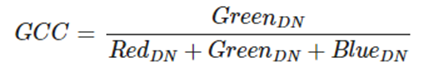
</div>

In [13]:
GCC=[]
DoY=[] ## day of year
timeseries_images_path=r'G:\Intern project\DATA SET\Labelled Dataset\Dataset testing multi class\DATASET_2016'

### Importing TimeSeries Images

In [14]:
import os
import glob
from tqdm import tqdm
import datetime

def datestdtojd (stddate):
    fmt='%Y-%m-%d'
    sdtdate = datetime.datetime.strptime(stddate, fmt)
    sdtdate = sdtdate.timetuple()
    jdate = sdtdate.tm_yday
    return(jdate)

for dirpath, dirname, filename in os.walk(timeseries_images_path):
    for file in tqdm([f for f in filename if(f.endswith('.JPG') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.JPEG'))],disable=False):
      
        year=file.split('_')[1]
        month=file.split('_')[2]
        day=file.split('_')[3]
        date=year+'-'+month+'-'+day
        
        src=dirpath + '/' + file
        img = cv2.imread(src)
        for roi in rois:
            B=img[roi[:,0],roi[:,1],0]
            G=img[roi[:,0],roi[:,1],1]
            R=img[roi[:,0],roi[:,1],2]
            Total_sum=img[roi[:,0],roi[:,1]].sum()
            GCC.append(G.sum()/Total_sum)
            DoY.append(datestdtojd(date))

0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 14.07it/s]


In [15]:
GCC =np.array(GCC)
DoY = np.array(DoY)

## Fitting Using Double sigmoid Function
<div>
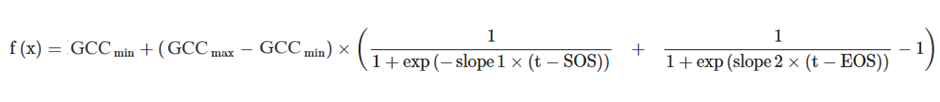
</div>
<div>
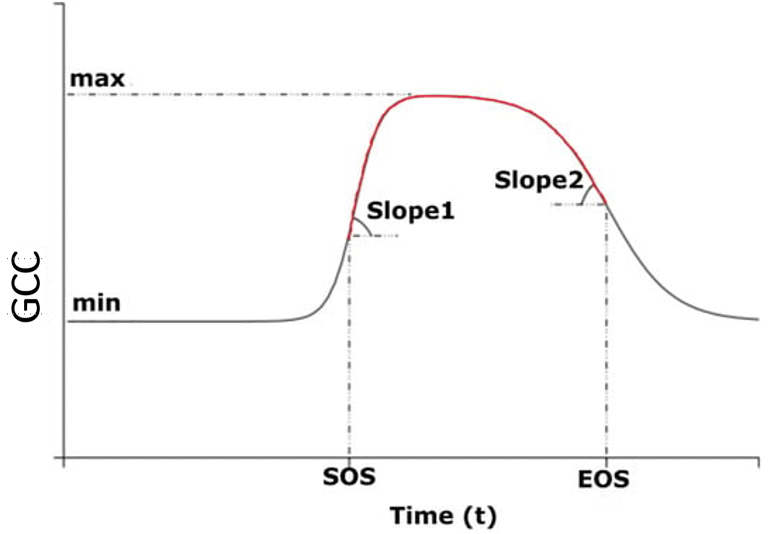
</div>

### Gradiant Descent For Optimization

In [243]:
import numpy as np
import matplotlib.pyplot as plt

class double_sigmoid:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.p = [0.3, 0.4, 0.05, 100, 0.05, 250] #min, max, slope1, SoS, slope2 , EoS 
        self.learning_rate = 0.001
        
    def predict(self, x=[]):
        if not len(x):
            x= self.X
        sigma1 = 1./(1+np.exp(-self.p[2]*(x-self.p[3])))
        sigma2 = 1./(1+np.exp(self.p[4]*(x-self.p[5])))
        y_pred = self.p[0] + (self.p[1]-self.p[0])*((sigma1 + sigma2-1))
        return y_pred
    
    def compute_cost(self):
        y_pred = self.predict(self.X)
        cost = 0.5*(y_pred-self.Y)**2
        return cost.sum()/len(self.X)

    def update_coeffs(self):
        
        self.Y_pred = self.predict()
        Y = self.Y
        Y_pred = self.Y_pred
        m = len(Y)
        lr = self.learning_rate 
        derivative = self.derivatives()
        
        ## Applying gradient Descent
        for i in range(6):
            self.p[i] = self.p[i] - (lr/m)*np.sum((Y_pred-Y)*derivative[i])
            
    def derivatives(self):
        y = self.Y_pred
        min, max, slope1, SoS, slope2 , EoS = self.p
        sigma1 = 1./(1+np.exp(-self.p[2]*(self.X-self.p[3])))
        sigma2 = 1./(1+np.exp(self.p[4]*(self.X-self.p[5])))
        derivative = [0]*6
        
        derivative[0] = -(y-max)/(max-min)
        derivative[1] = (y-min)/(max-min)
        derivative[2] = ((sigma1)*(sigma1-1))*(max-min)*(self.X-SoS)
        derivative[3] = ((sigma1)*(1.- sigma1))*(max-min)*slope1
        derivative[4] = ((sigma2)*(1.- sigma2))*(max-min)*(self.X-EoS)
        derivative[5] = ((sigma2)*(sigma2-1))*(max-min)*slope2
        
        return derivative
        



In [246]:
regressor = double_sigmoid(DoY, GCC)
iterations = 0
costs = []

while 1:
    Y_pred = regressor.predict()
    cost = regressor.compute_cost()
    if len(costs) and (abs(cost-costs[-1])<1e-9):
        break
    costs.append(cost)
    regressor.update_coeffs()    
    iterations += 1


### Plotting

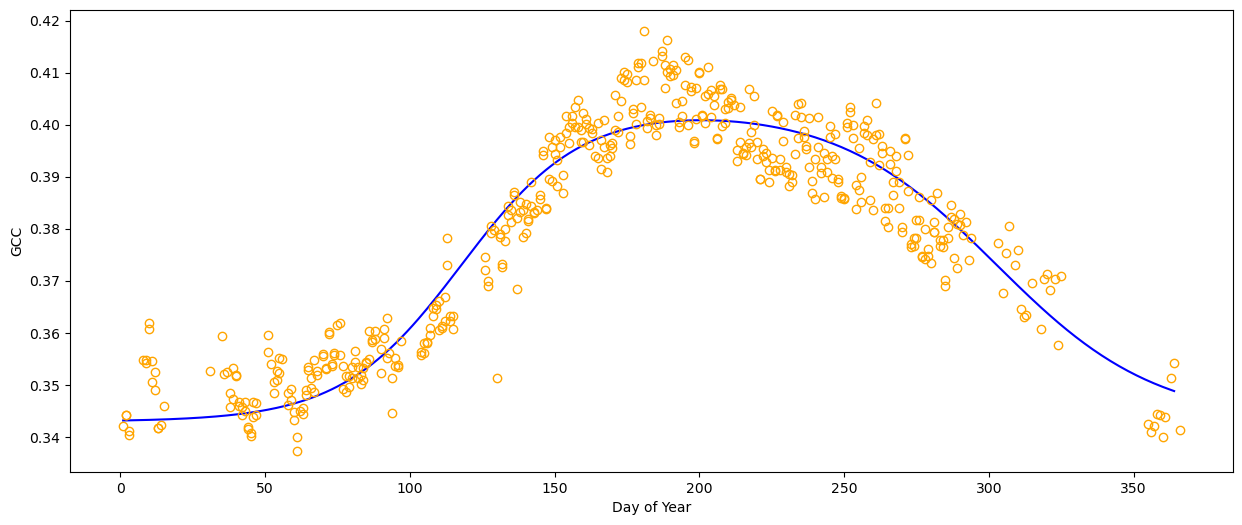

In [237]:
days = np.arange(1,365)
GCC_pred = regressor.predict(days)
plt.figure(figsize=(15, 6))
plt.errorbar(DoY,GCC, fmt="o",color = 'orange', mfc="none")
plt.ylabel('GCC')
plt.xlabel("Day of Year")
plt.plot(days, GCC_pred, '-', color = 'blue')
plt.show()
plt.close()

#### Phenological Parameters

In [238]:

min, max, slope1, SoS, slope2 , EoS  = regressor.p
print('Minmum GCC: {:.2}'.format(min))
print('Maximum GCC: {:.2}'.format(max))
print('Start of season(DoY): ',int(SoS))
print('End of season: ',int(EoS))
print('Greenary increasing rate: {:.2}'.format(slope1))
print('Greenary decreasing rate: {:.2}'.format(slope2))

Minmum GCC: 0.34
Maximum GCC: 0.4
Start of season(DoY):  117
End of season:  302
Greenary increasing rate: 0.048
Greenary decreasing rate: 0.036
